# Flood Model Training Notebook

Train a Flood ConvLSTM Model using `usl_models` lib.

In [2]:
from google.cloud import firestore, storage

firestore_client = firestore.Client(project="climateiq-test")
storage_client = storage.Client(project="climateiq-test")


Current project: climateiq


In [4]:
import os
os.environ["GOOGLE_CLOUD_PROJECT"] = "climateiq-test"


In [5]:
from google.cloud import storage
print(storage.Client().project)


climateiq-test


In [6]:
from google.cloud import storage
client = storage.Client()
print("Current project:", client.project)


Current project: climateiq-test


In [16]:

import tensorflow as tf
import keras_tuner
import time
import keras
import logging
from usl_models.flood_ml import constants
from usl_models.flood_ml.model import FloodModel
from usl_models.flood_ml.model_params import FloodModelParams
from usl_models.flood_ml.dataset import load_dataset_windowed, load_dataset

# Setup
logging.getLogger().setLevel(logging.WARNING)
keras.utils.set_random_seed(812)

for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
    
timestamp = time.strftime("%Y%m%d-%H%M%S")

# Cities and their config folders
city_config_mapping = {
    "Manhattan": "Manhattan_config",
    "Atlanta": "Atlanta_config",
    "Phoenix_SM": "PHX_SM",
    "Phoenix_PV": "PHX_PV",
}

# Rainfall files you want
rainfall_files = [5]  # Only 5 and 6

# Generate sim_names
sim_names = []
for city, config in city_config_mapping.items():
    for rain_id in rainfall_files:
        sim_name = f"{city}-{config}/Rainfall_Data_{rain_id}.txt"
        sim_names.append(sim_name)

print(f"Training on {len(sim_names)} simulations.")
for s in sim_names:
    print(s)

# Now load dataset
train_dataset = load_dataset_windowed(
    sim_names=sim_names,
    batch_size=4,
    dataset_split='train'
).cache()

validation_dataset = load_dataset_windowed(
    sim_names=sim_names,
    batch_size=4,
    dataset_split='val'
).cache()

# Now you can pass these into your model training like usual


Training on 4 simulations.
Manhattan-Manhattan_config/Rainfall_Data_5.txt
Atlanta-Atlanta_config/Rainfall_Data_5.txt
Phoenix_SM-PHX_SM/Rainfall_Data_5.txt
Phoenix_PV-PHX_PV/Rainfall_Data_5.txt


In [11]:
from google.cloud import firestore, storage
from usl_models.flood_ml import metastore

# Force the project here if you want to be explicit:
FIRESTORE_PROJECT = None  # or "climateiq-test"
firestore_client = firestore.Client(project=FIRESTORE_PROJECT)

def preview_uris(sim_name: str, split: str = "train", limit: int = 3):
    # Temporal (rainfall) vector
    tmeta = metastore.get_temporal_feature_metadata(firestore_client, sim_name)
    print(f"[temporal] {sim_name}: {tmeta.get('as_vector_gcs_uri')}")

    # Feature/label chunks
    pairs = metastore.get_spatial_feature_and_label_chunk_metadata(
        firestore_client, sim_name, split
    )
    print(f"[{split}] showing first {min(limit, len(pairs))} chunks:")
    for (fmeta, lmeta) in pairs[:limit]:
        print("  feature:", fmeta.get("feature_matrix_path"))
        print("  label  :", lmeta.get("gcs_uri"))

for s in sim_names[:2]:  # sample a couple
    preview_uris(s, "train", limit=2)


[temporal] Manhattan-Manhattan_config/Rainfall_Data_5.txt: gs://test-climateiq-study-area-feature-chunks/rainfall/Manhattan_config/Rainfall_Data_5.npy
[train] showing first 2 chunks:
  feature: gs://test-climateiq-study-area-feature-chunks/Manhattan/scaled_chunk_1_10.npy
  label  : gs://test-climateiq-study-area-label-chunks/Manhattan/Manhattan_config/Rainfall_Data_5.txt/1_10.npy
  feature: gs://test-climateiq-study-area-feature-chunks/Manhattan/scaled_chunk_1_7.npy
  label  : gs://test-climateiq-study-area-label-chunks/Manhattan/Manhattan_config/Rainfall_Data_5.txt/1_7.npy
[temporal] Atlanta-Atlanta_config/Rainfall_Data_5.txt: gs://test-climateiq-study-area-feature-chunks/rainfall/Atlanta_config/Rainfall_Data_5.npy
[train] showing first 2 chunks:
  feature: gs://test-climateiq-study-area-feature-chunks/Atlanta/scaled_chunk_1_1.npy
  label  : gs://test-climateiq-study-area-label-chunks/Atlanta/Atlanta_config/Rainfall_Data_5.txt/1_1.npy
  feature: gs://test-climateiq-study-area-feature-

In [17]:

tuner = keras_tuner.BayesianOptimization(
    FloodModel.get_hypermodel(
        lstm_units=[32, 64, 128],
        lstm_kernel_size=[3, 5],
        lstm_dropout=[0.2, 0.3],
        lstm_recurrent_dropout=[0.2, 0.3],
        n_flood_maps=[5],
        m_rainfall=[6],
    ),
        objective="val_loss",
        max_trials=1,
        project_name=f"logs/htune_project_{timestamp}",
)

tuner.search_space_summary()


Search space summary
Default search space size: 6
lstm_units (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
lstm_kernel_size (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
lstm_dropout (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3], 'ordered': True}
lstm_recurrent_dropout (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3], 'ordered': True}
n_flood_maps (Choice)
{'default': 5, 'conditions': [], 'values': [5], 'ordered': True}
m_rainfall (Choice)
{'default': 6, 'conditions': [], 'values': [6], 'ordered': True}


In [18]:
log_dir = f"logs/htune_project_{timestamp}"
print(log_dir)
tb_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
tuner.search(train_dataset, epochs=1, validation_data=validation_dataset , callbacks=[tb_callback])
best_model, best_hp = tuner.get_best_models()[0], tuner.get_best_hyperparameters()[0]
best_hp.values

Trial 1 Complete [00h 03m 06s]
val_loss: 0.0031034061685204506

Best val_loss So Far: 0.0031034061685204506
Total elapsed time: 00h 03m 06s


{'lstm_units': 64,
 'lstm_kernel_size': 3,
 'lstm_dropout': 0.3,
 'lstm_recurrent_dropout': 0.3,
 'n_flood_maps': 5,
 'm_rainfall': 6}

In [20]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define final parameters and model
final_params = FloodModel.Params(**best_hp.values)
model = FloodModel(params=final_params)

# Define callbacks
callbacks = [
    keras.callbacks.TensorBoard(log_dir=log_dir),
    ModelCheckpoint(
        filepath=log_dir + "/checkpoint",
        save_best_only=True,
        monitor="val_loss",
        mode="min",
        save_format="tf"
    ),
    EarlyStopping(               # <--- ADD THIS
        monitor="val_loss",       # What to monitor
        patience=10,              # Number of epochs with no improvement to wait
        restore_best_weights=True, # Restore model weights from best epoch
        mode="min"                # "min" because lower val_loss is better
    )
]

# Train
model.fit(
    train_dataset,
    validation_dataset,
    epochs=20,
    callbacks=callbacks
)

# Save final model
model.save_model(log_dir + "/model")


Epoch 1/20


2025-08-27 18:24:11.167782: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inflood_conv_lstm_2/conv_lstm/conv_lstm2d_2/while/body/_1/flood_conv_lstm_2/conv_lstm/conv_lstm2d_2/while/dropout_7/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


    159/Unknown - 39s 212ms/step - loss: 0.0049 - mean_absolute_error: 0.0166 - root_mean_squared_error: 0.0699

2025-08-27 18:24:52.968408: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13811986920852099938


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/checkpoint/assets


159/159 [==============================] - 49s 278ms/step - loss: 0.0049 - mean_absolute_error: 0.0166 - root_mean_squared_error: 0.0699 - val_loss: 0.0033 - val_mean_absolute_error: 0.0135 - val_root_mean_squared_error: 0.0571
Epoch 2/20
159/159 [==============================] - ETA: 0s - loss: 0.0028 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0529WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/checkpoint/assets


159/159 [==============================] - 44s 280ms/step - loss: 0.0028 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0529 - val_loss: 0.0027 - val_mean_absolute_error: 0.0117 - val_root_mean_squared_error: 0.0523
Epoch 3/20
159/159 [==============================] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0488WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/checkpoint/assets


159/159 [==============================] - 44s 275ms/step - loss: 0.0024 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0488 - val_loss: 0.0025 - val_mean_absolute_error: 0.0113 - val_root_mean_squared_error: 0.0498
Epoch 4/20
159/159 [==============================] - ETA: 0s - loss: 0.0022 - mean_absolute_error: 0.0116 - root_mean_squared_error: 0.0472WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/checkpoint/assets


159/159 [==============================] - 44s 275ms/step - loss: 0.0022 - mean_absolute_error: 0.0116 - root_mean_squared_error: 0.0472 - val_loss: 0.0023 - val_mean_absolute_error: 0.0109 - val_root_mean_squared_error: 0.0482
Epoch 5/20
159/159 [==============================] - ETA: 0s - loss: 0.0021 - mean_absolute_error: 0.0113 - root_mean_squared_error: 0.0457WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/checkpoint/assets


159/159 [==============================] - 44s 275ms/step - loss: 0.0021 - mean_absolute_error: 0.0113 - root_mean_squared_error: 0.0457 - val_loss: 0.0022 - val_mean_absolute_error: 0.0107 - val_root_mean_squared_error: 0.0469
Epoch 6/20
159/159 [==============================] - ETA: 0s - loss: 0.0020 - mean_absolute_error: 0.0111 - root_mean_squared_error: 0.0448WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/checkpoint/assets


159/159 [==============================] - 45s 280ms/step - loss: 0.0020 - mean_absolute_error: 0.0111 - root_mean_squared_error: 0.0448 - val_loss: 0.0021 - val_mean_absolute_error: 0.0103 - val_root_mean_squared_error: 0.0459
Epoch 7/20
159/159 [==============================] - ETA: 0s - loss: 0.0019 - mean_absolute_error: 0.0108 - root_mean_squared_error: 0.0437WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/checkpoint/assets


159/159 [==============================] - 44s 275ms/step - loss: 0.0019 - mean_absolute_error: 0.0108 - root_mean_squared_error: 0.0437 - val_loss: 0.0020 - val_mean_absolute_error: 0.0101 - val_root_mean_squared_error: 0.0449
Epoch 8/20
159/159 [==============================] - ETA: 0s - loss: 0.0018 - mean_absolute_error: 0.0106 - root_mean_squared_error: 0.0429WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/checkpoint/assets


159/159 [==============================] - 44s 275ms/step - loss: 0.0018 - mean_absolute_error: 0.0106 - root_mean_squared_error: 0.0429 - val_loss: 0.0019 - val_mean_absolute_error: 0.0100 - val_root_mean_squared_error: 0.0441
Epoch 9/20
159/159 [==============================] - ETA: 0s - loss: 0.0018 - mean_absolute_error: 0.0105 - root_mean_squared_error: 0.0421WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/checkpoint/assets


159/159 [==============================] - 44s 274ms/step - loss: 0.0018 - mean_absolute_error: 0.0105 - root_mean_squared_error: 0.0421 - val_loss: 0.0019 - val_mean_absolute_error: 0.0099 - val_root_mean_squared_error: 0.0434
Epoch 10/20
159/159 [==============================] - ETA: 0s - loss: 0.0017 - mean_absolute_error: 0.0103 - root_mean_squared_error: 0.0415WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/checkpoint/assets


159/159 [==============================] - 45s 280ms/step - loss: 0.0017 - mean_absolute_error: 0.0103 - root_mean_squared_error: 0.0415 - val_loss: 0.0018 - val_mean_absolute_error: 0.0097 - val_root_mean_squared_error: 0.0426
Epoch 11/20
159/159 [==============================] - ETA: 0s - loss: 0.0017 - mean_absolute_error: 0.0103 - root_mean_squared_error: 0.0410WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/checkpoint/assets


159/159 [==============================] - 44s 275ms/step - loss: 0.0017 - mean_absolute_error: 0.0103 - root_mean_squared_error: 0.0410 - val_loss: 0.0018 - val_mean_absolute_error: 0.0096 - val_root_mean_squared_error: 0.0421
Epoch 12/20
159/159 [==============================] - ETA: 0s - loss: 0.0016 - mean_absolute_error: 0.0101 - root_mean_squared_error: 0.0402WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/checkpoint/assets


159/159 [==============================] - 44s 275ms/step - loss: 0.0016 - mean_absolute_error: 0.0101 - root_mean_squared_error: 0.0402 - val_loss: 0.0017 - val_mean_absolute_error: 0.0095 - val_root_mean_squared_error: 0.0414
Epoch 13/20
159/159 [==============================] - ETA: 0s - loss: 0.0016 - mean_absolute_error: 0.0101 - root_mean_squared_error: 0.0401WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/checkpoint/assets


159/159 [==============================] - 44s 274ms/step - loss: 0.0016 - mean_absolute_error: 0.0101 - root_mean_squared_error: 0.0401 - val_loss: 0.0017 - val_mean_absolute_error: 0.0094 - val_root_mean_squared_error: 0.0411
Epoch 14/20
159/159 [==============================] - ETA: 0s - loss: 0.0016 - mean_absolute_error: 0.0100 - root_mean_squared_error: 0.0396WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/checkpoint/assets


159/159 [==============================] - 45s 281ms/step - loss: 0.0016 - mean_absolute_error: 0.0100 - root_mean_squared_error: 0.0396 - val_loss: 0.0016 - val_mean_absolute_error: 0.0094 - val_root_mean_squared_error: 0.0406
Epoch 15/20
159/159 [==============================] - ETA: 0s - loss: 0.0015 - mean_absolute_error: 0.0098 - root_mean_squared_error: 0.0390WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/checkpoint/assets


159/159 [==============================] - 44s 276ms/step - loss: 0.0015 - mean_absolute_error: 0.0098 - root_mean_squared_error: 0.0390 - val_loss: 0.0016 - val_mean_absolute_error: 0.0092 - val_root_mean_squared_error: 0.0400
Epoch 16/20
159/159 [==============================] - ETA: 0s - loss: 0.0015 - mean_absolute_error: 0.0099 - root_mean_squared_error: 0.0389WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/checkpoint/assets


159/159 [==============================] - 44s 275ms/step - loss: 0.0015 - mean_absolute_error: 0.0099 - root_mean_squared_error: 0.0389 - val_loss: 0.0016 - val_mean_absolute_error: 0.0091 - val_root_mean_squared_error: 0.0397
Epoch 17/20
159/159 [==============================] - ETA: 0s - loss: 0.0015 - mean_absolute_error: 0.0097 - root_mean_squared_error: 0.0383WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/checkpoint/assets


159/159 [==============================] - 44s 274ms/step - loss: 0.0015 - mean_absolute_error: 0.0097 - root_mean_squared_error: 0.0383 - val_loss: 0.0015 - val_mean_absolute_error: 0.0090 - val_root_mean_squared_error: 0.0392
Epoch 18/20
159/159 [==============================] - 40s 250ms/step - loss: 0.0015 - mean_absolute_error: 0.0098 - root_mean_squared_error: 0.0384 - val_loss: 0.0016 - val_mean_absolute_error: 0.0092 - val_root_mean_squared_error: 0.0395
Epoch 19/20
159/159 [==============================] - ETA: 0s - loss: 0.0014 - mean_absolute_error: 0.0097 - root_mean_squared_error: 0.0378WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/checkpoint/assets


159/159 [==============================] - 44s 275ms/step - loss: 0.0014 - mean_absolute_error: 0.0097 - root_mean_squared_error: 0.0378 - val_loss: 0.0015 - val_mean_absolute_error: 0.0090 - val_root_mean_squared_error: 0.0386
Epoch 20/20
159/159 [==============================] - ETA: 0s - loss: 0.0014 - mean_absolute_error: 0.0096 - root_mean_squared_error: 0.0374WARNING:tensorflow:Model's `__init__()` arguments contain non-serializable objects. Please implement a `get_config()` method in the subclassed Model for proper saving and loading. Defaulting to empty config.


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/checkpoint/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/checkpoint/assets


159/159 [==============================] - 45s 282ms/step - loss: 0.0014 - mean_absolute_error: 0.0096 - root_mean_squared_error: 0.0374 - val_loss: 0.0015 - val_mean_absolute_error: 0.0089 - val_root_mean_squared_error: 0.0382


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/model/assets


INFO:tensorflow:Assets written to: logs/htune_project_20250827-180924/model/assets


In [21]:
# # Test calling the model on some data.
inputs, labels_ = next(iter(train_dataset))
prediction = model.call(inputs)
prediction.shape

TensorShape([4, 1000, 1000, 1])

In [24]:

import tensorflow as tf
# Path to your saved model
model_path = "/home/vupparal/climateiq-cnn-2/logs/htune_project_20250827-180924/model"

# Load the model
model = tf.keras.models.load_model(model_path)

In [ ]:
# # Test calling the model for n predictions
#full_dataset = load_dataset(sim_names=sim_names, batch_size=1,dataset_split="test")
#inputs, labels = next(iter(full_dataset))
#predictions = model.call_n(inputs, n=4)
#predictions.shape

AttributeError: 'FloodConvLSTM' object has no attribute 'call_n'

2025-08-27 18:41:32.213707: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'StatefulPartitionedCall/conv_lstm/StatefulPartitionedCall/conv_lstm2d_2/StatefulPartitionedCall/while/next_iteration/_173-0-0-TransposeNCHWToNHWC-LayoutOptimizer' -> 'StatefulPartitionedCall/conv_lstm/StatefulPartitionedCall/conv_lstm2d_2/StatefulPartitionedCall/while/merge/_146', 'StatefulPartitionedCall/conv_lstm/StatefulPartitionedCall/conv_lstm2d_2/StatefulPartitionedCall/while/body/_130/while/mul_10' -> 'StatefulPartitionedCall/conv_lstm/StatefulPartitionedCall/conv_lstm2d_2/StatefulPartitionedCall/while/body/_130/while/add_5'}.



Sample 1 Prediction Stats:
  Min: 0.0
  Max: 0.28332657
  Mean: 0.0018238173


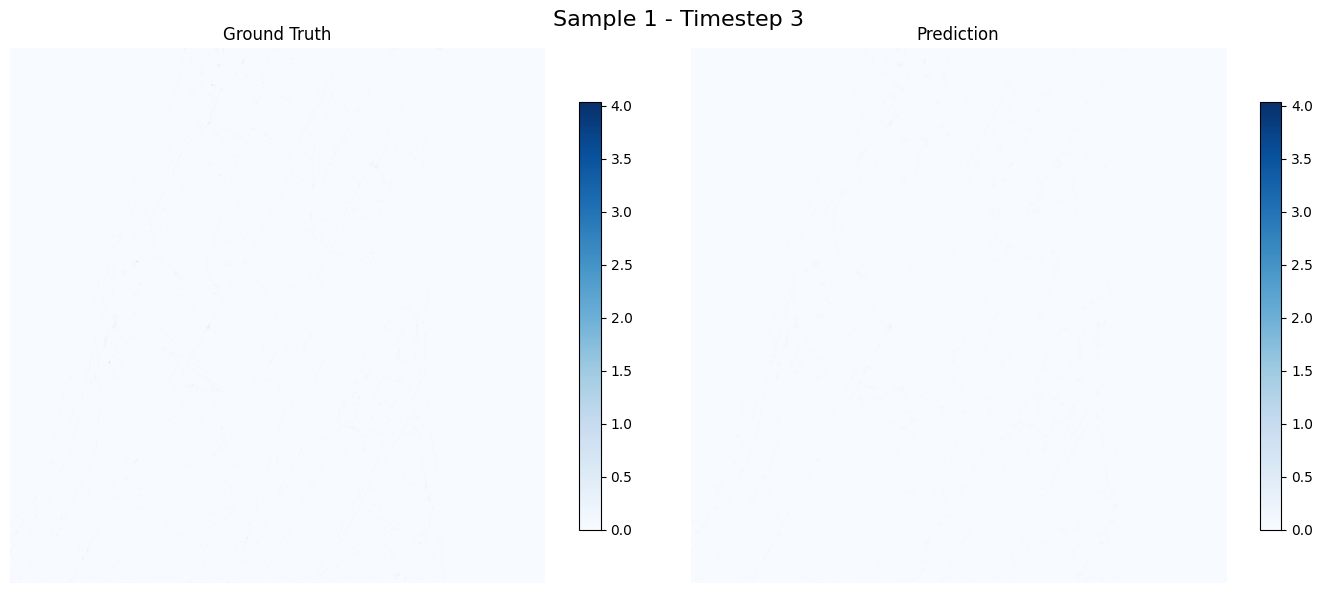


Sample 2 Prediction Stats:
  Min: 0.0
  Max: 5.010778
  Mean: 0.021656856


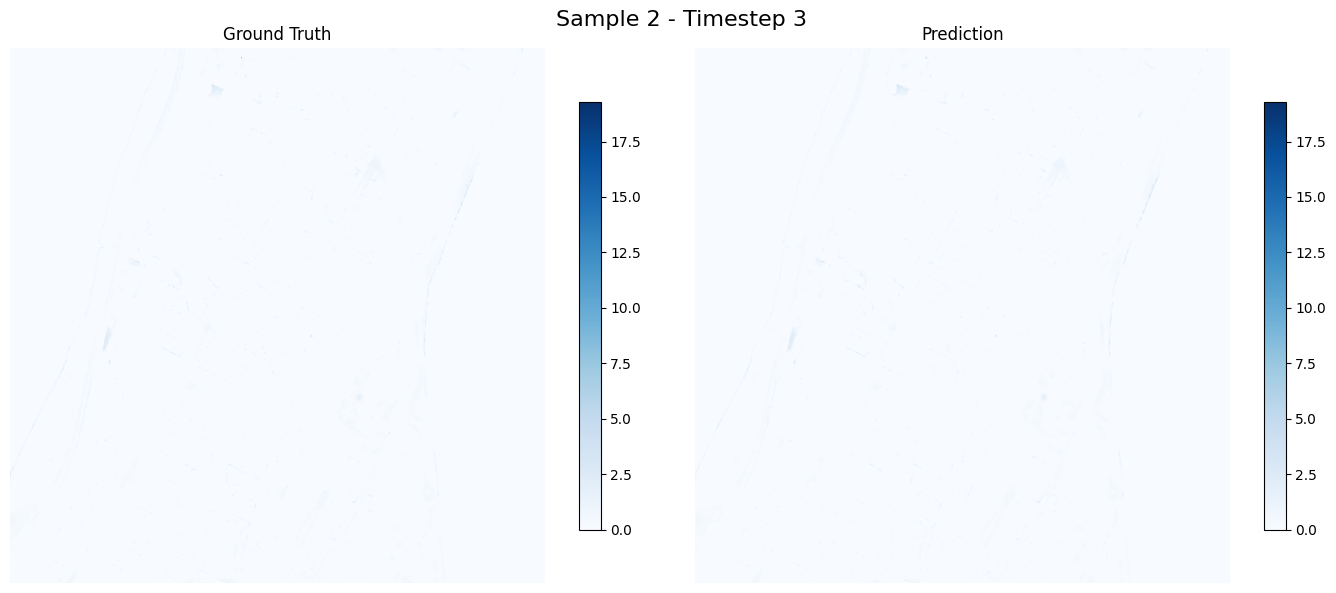


Sample 3 Prediction Stats:
  Min: 0.0
  Max: 6.3986382
  Mean: 0.032214973


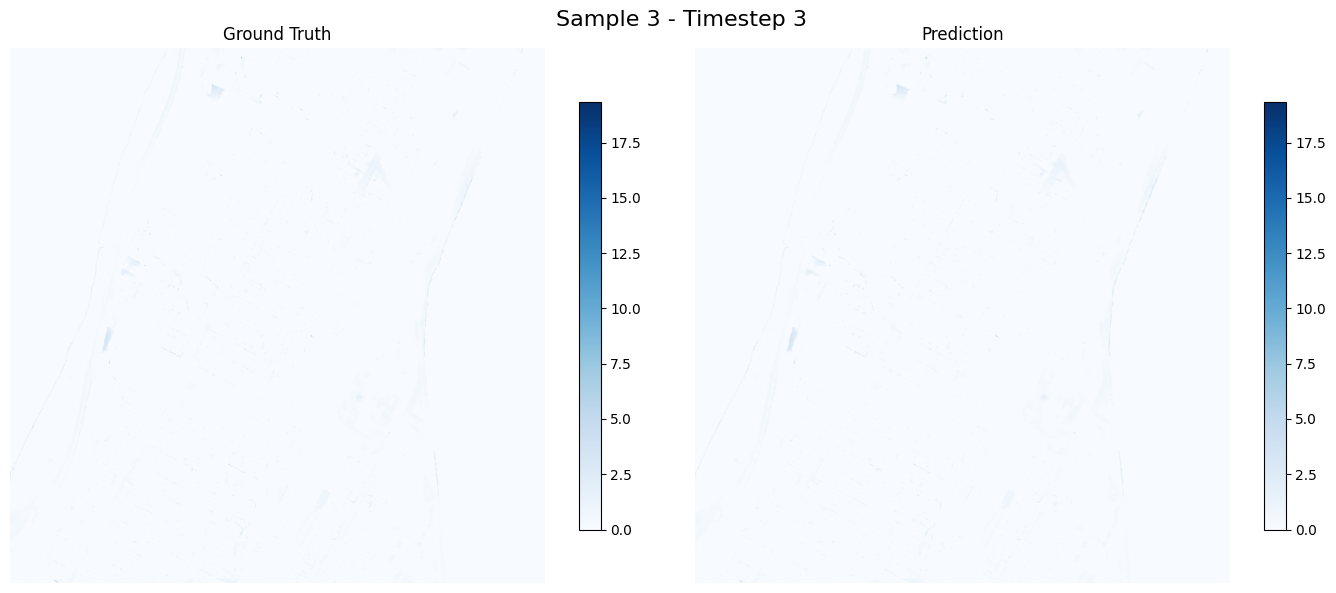


Sample 4 Prediction Stats:
  Min: 0.0
  Max: 6.412554
  Mean: 0.009196077


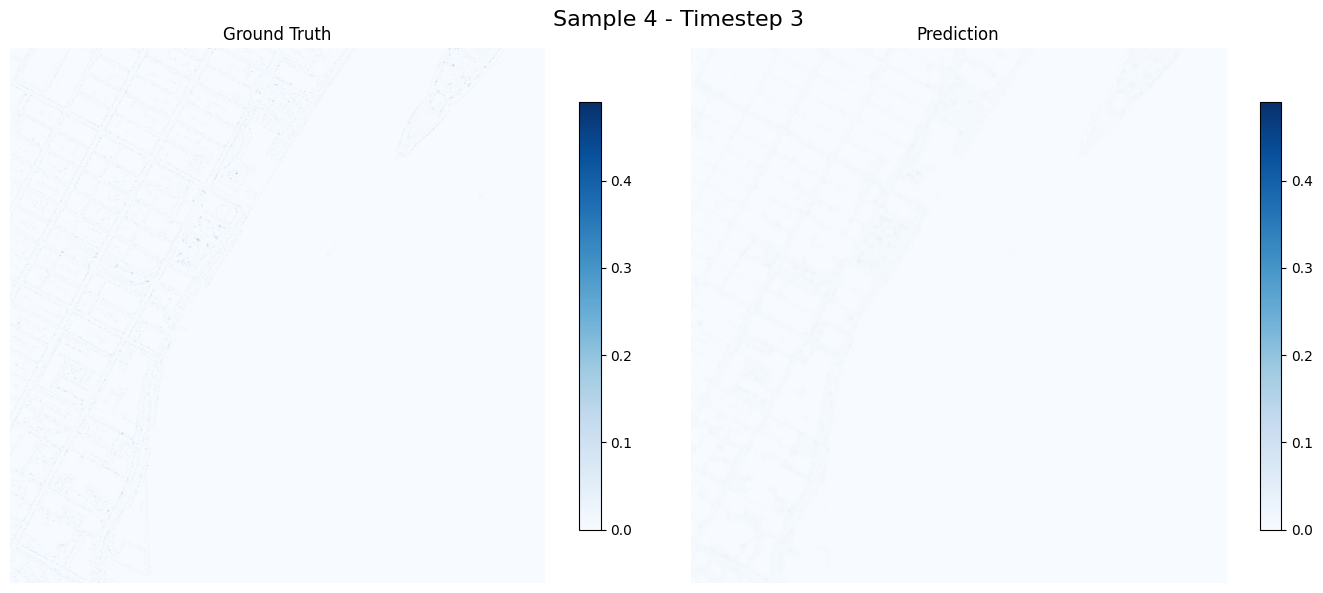


Sample 5 Prediction Stats:
  Min: 0.0
  Max: 3.0376782
  Mean: 0.0097106295


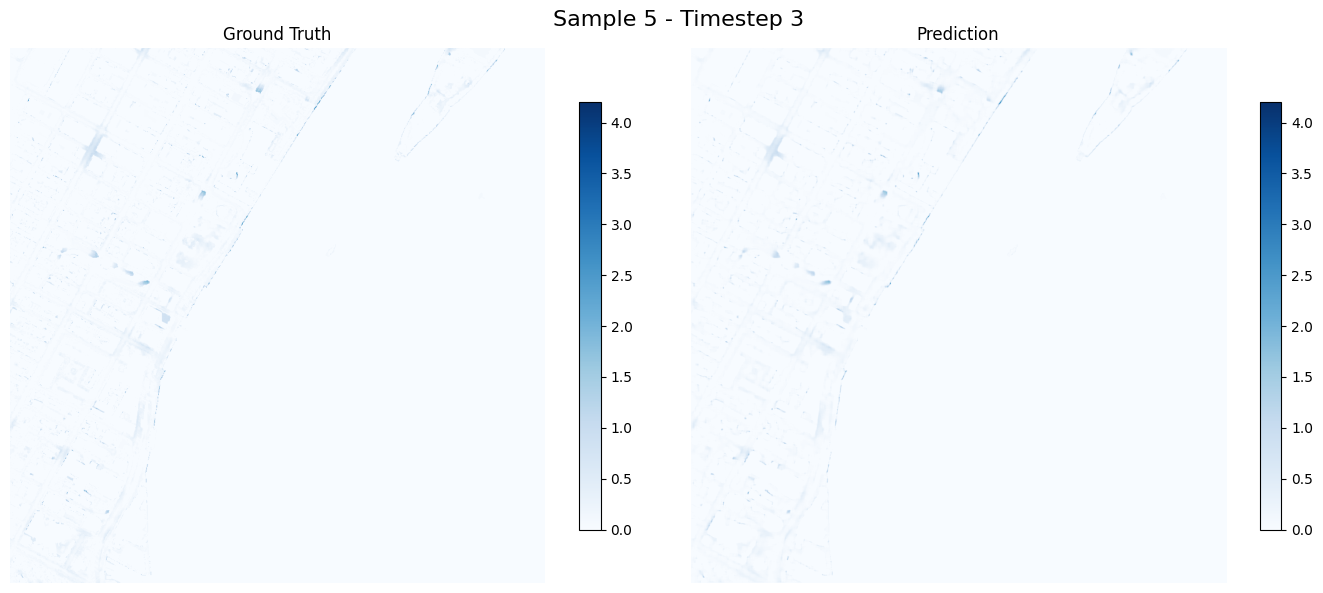


Sample 6 Prediction Stats:
  Min: 0.0
  Max: 3.5977066
  Mean: 0.019186588


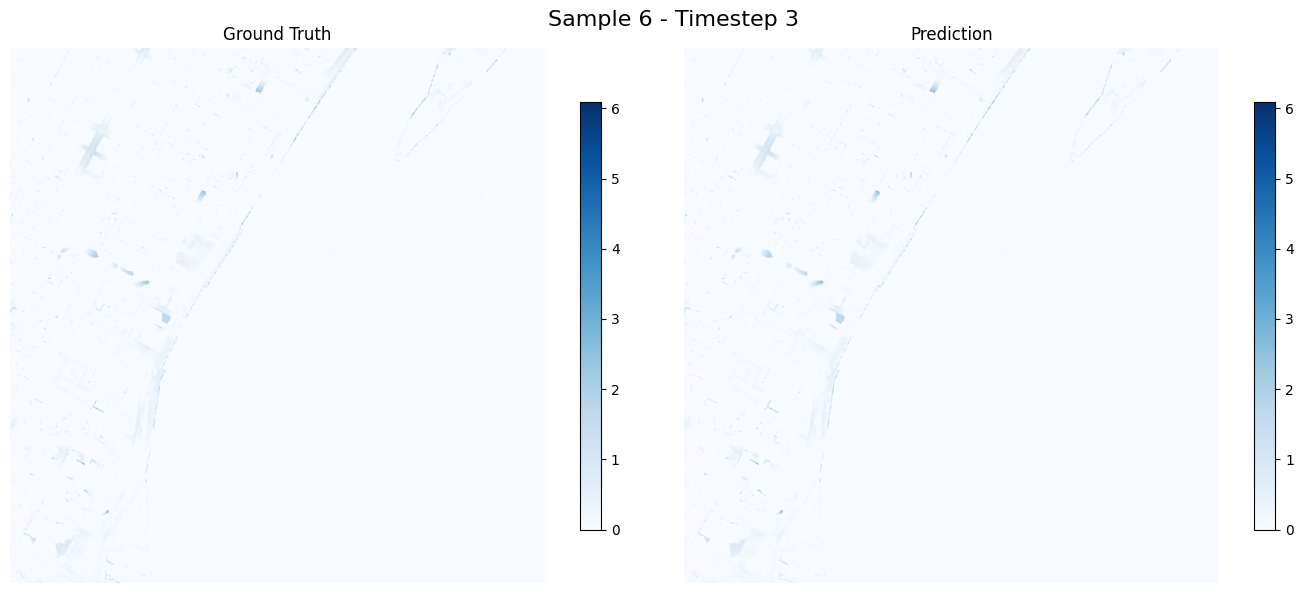


Sample 7 Prediction Stats:
  Min: 0.0
  Max: 3.7241719
  Mean: 0.011174299


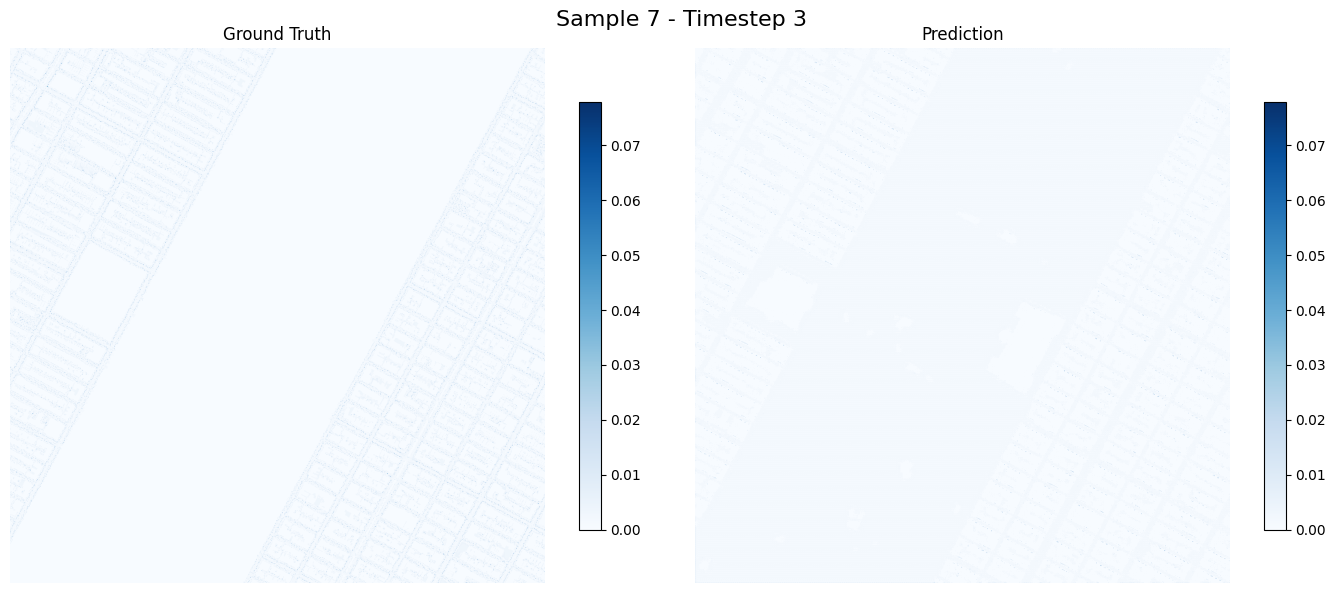


Sample 8 Prediction Stats:
  Min: 0.0
  Max: 2.3091807
  Mean: 0.01111226


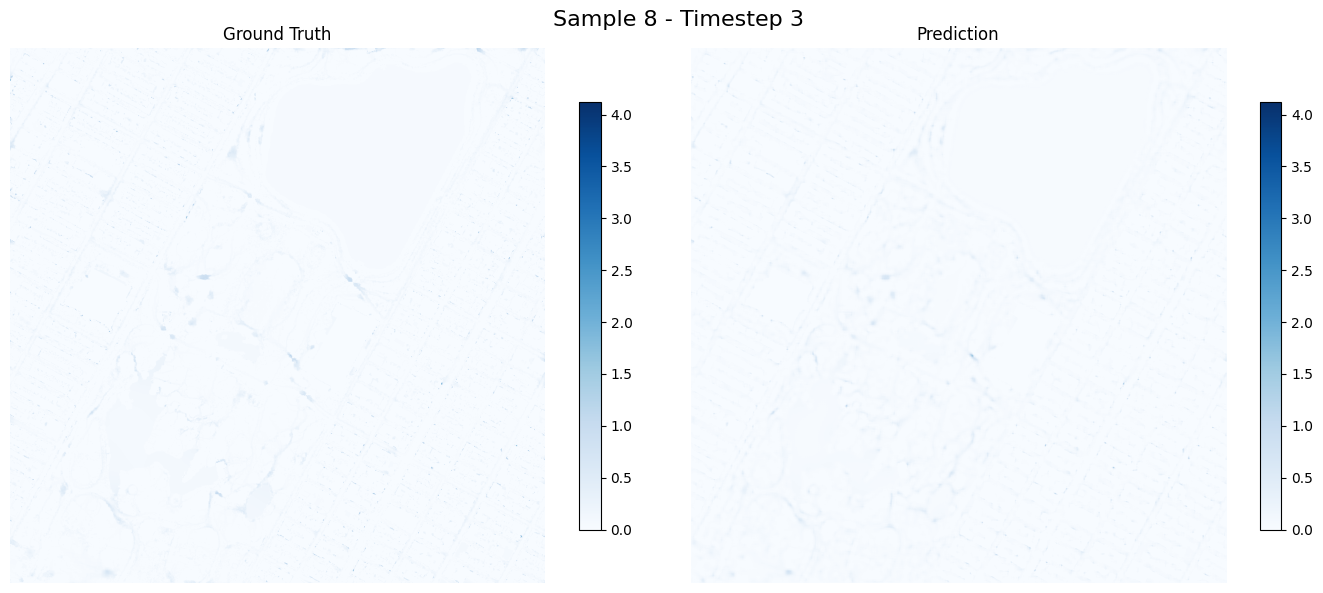


Sample 9 Prediction Stats:
  Min: 0.0
  Max: 3.6402903
  Mean: 0.036644477


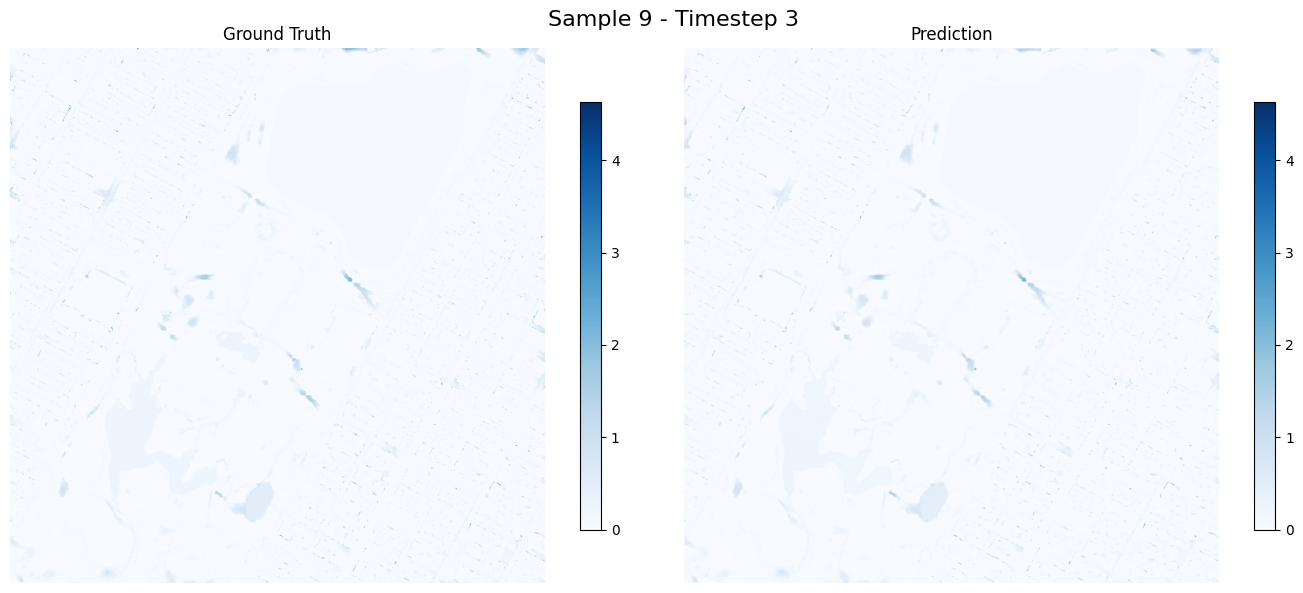


Sample 10 Prediction Stats:
  Min: 0.0
  Max: 3.587356
  Mean: 0.030726044


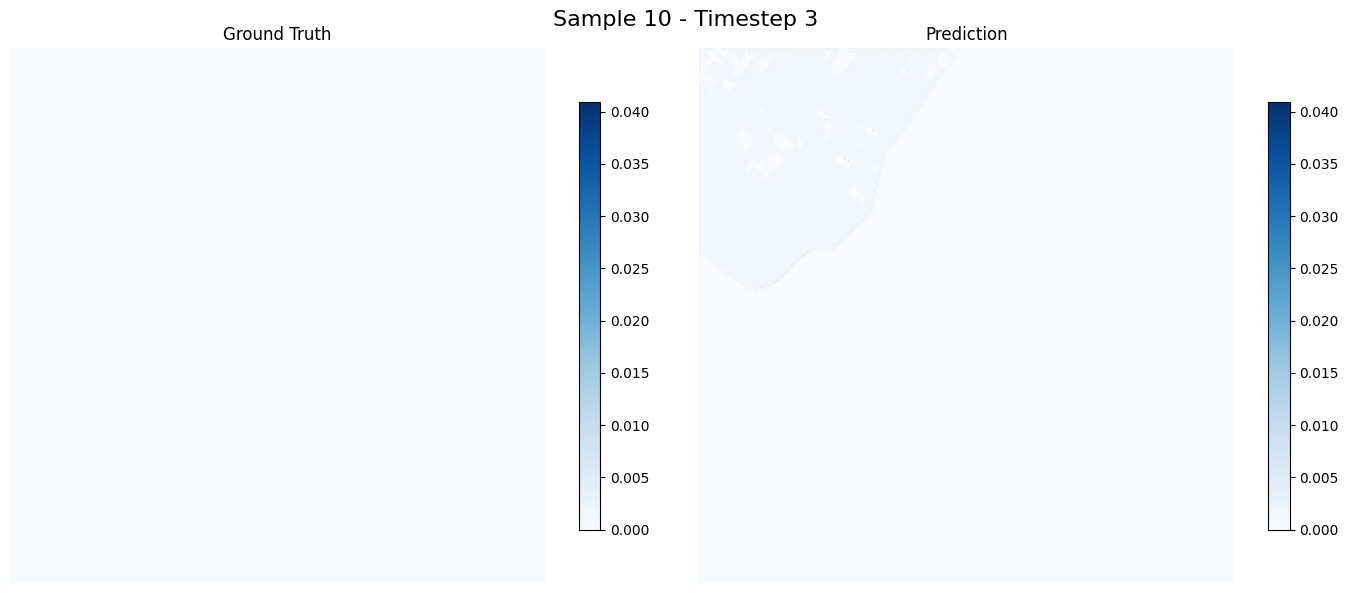


Sample 11 Prediction Stats:
  Min: 0.0
  Max: 0.9207402
  Mean: 0.00080864935


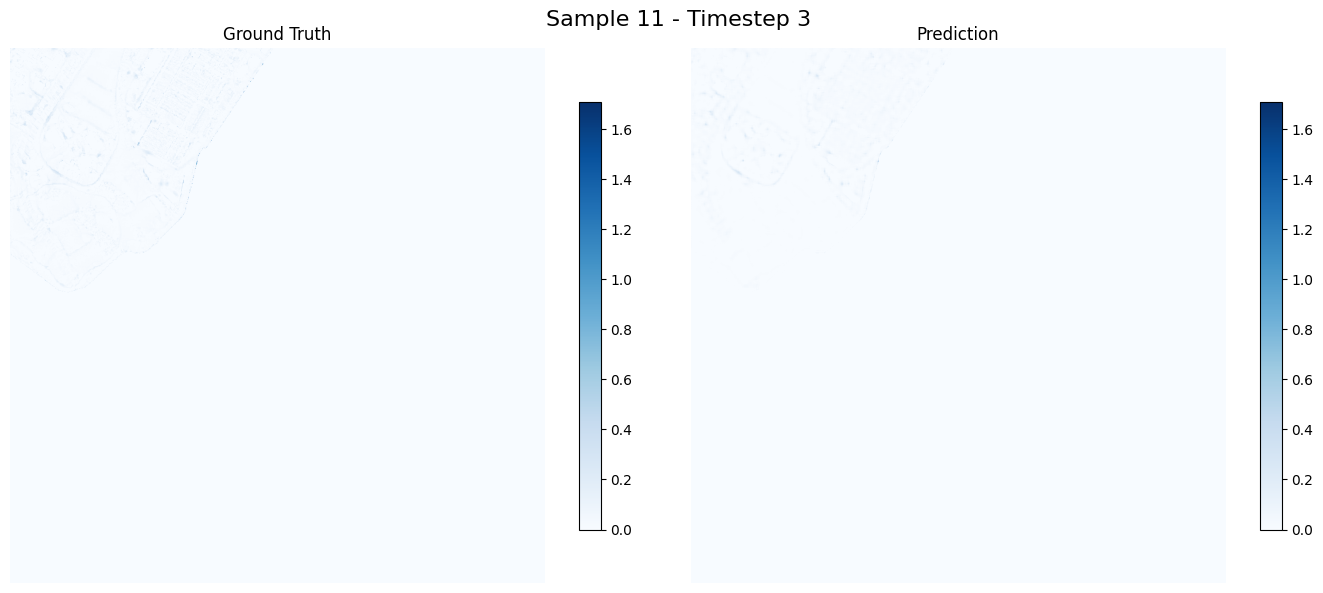


Sample 12 Prediction Stats:
  Min: 0.0
  Max: 4.0425396
  Mean: 0.0058307457


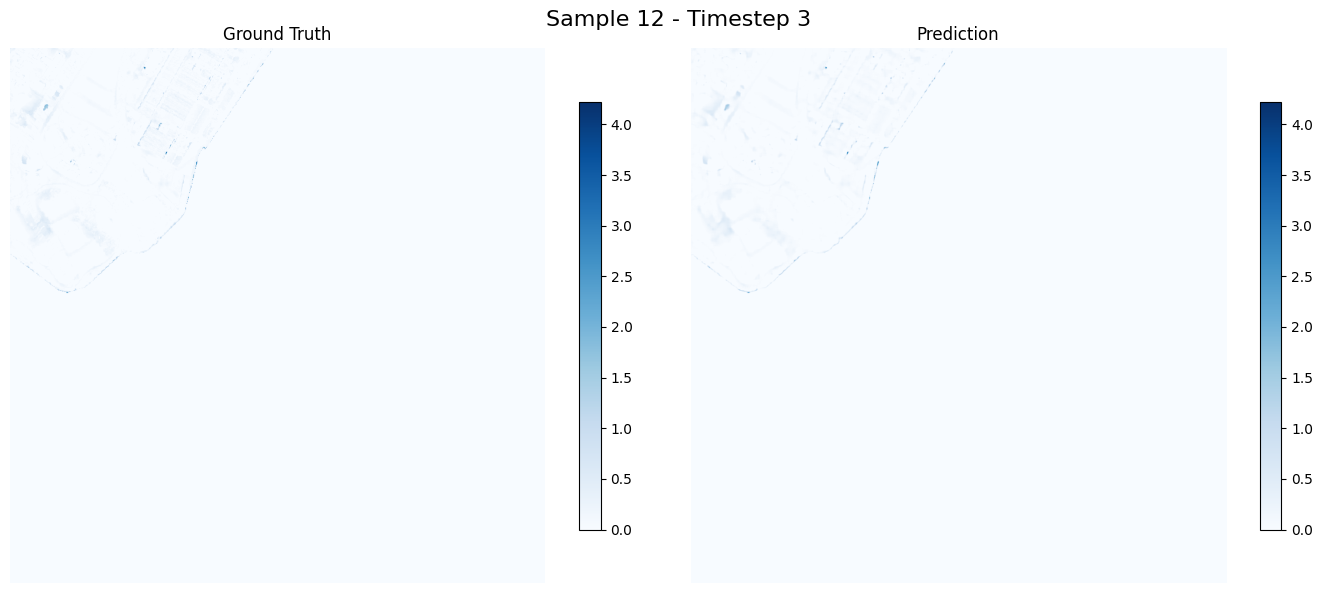


Sample 13 Prediction Stats:
  Min: 0.0
  Max: 4.3856153
  Mean: 0.006706098


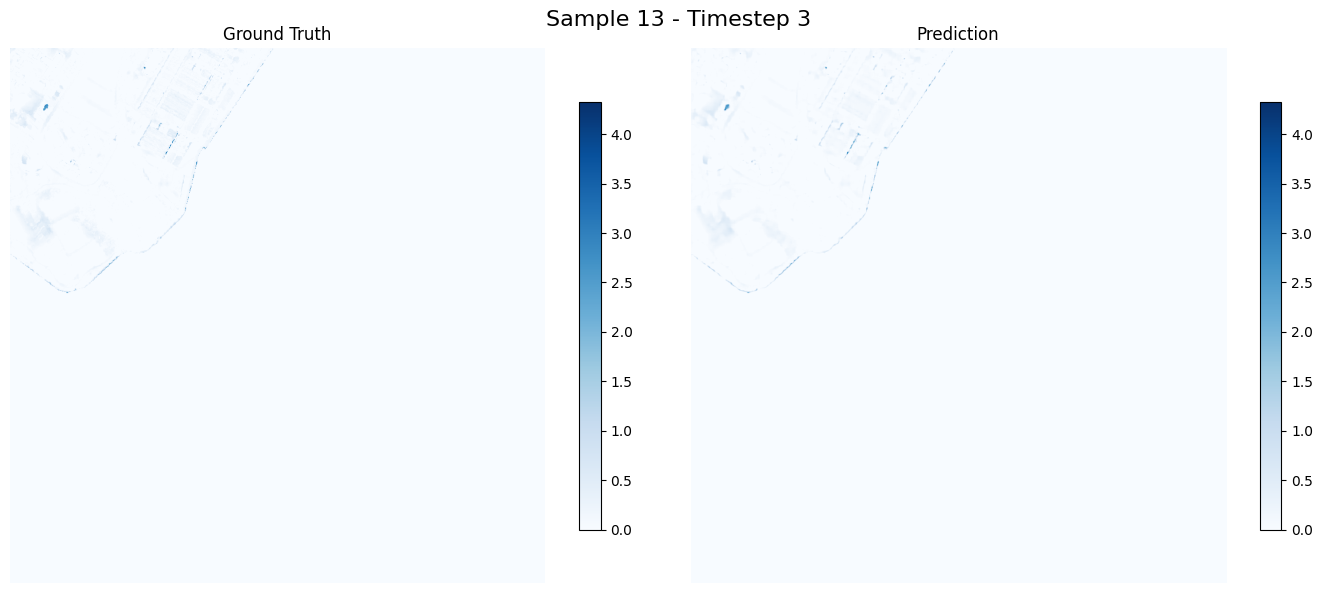


Sample 14 Prediction Stats:
  Min: 0.0
  Max: 0.46161735
  Mean: 0.0023945293


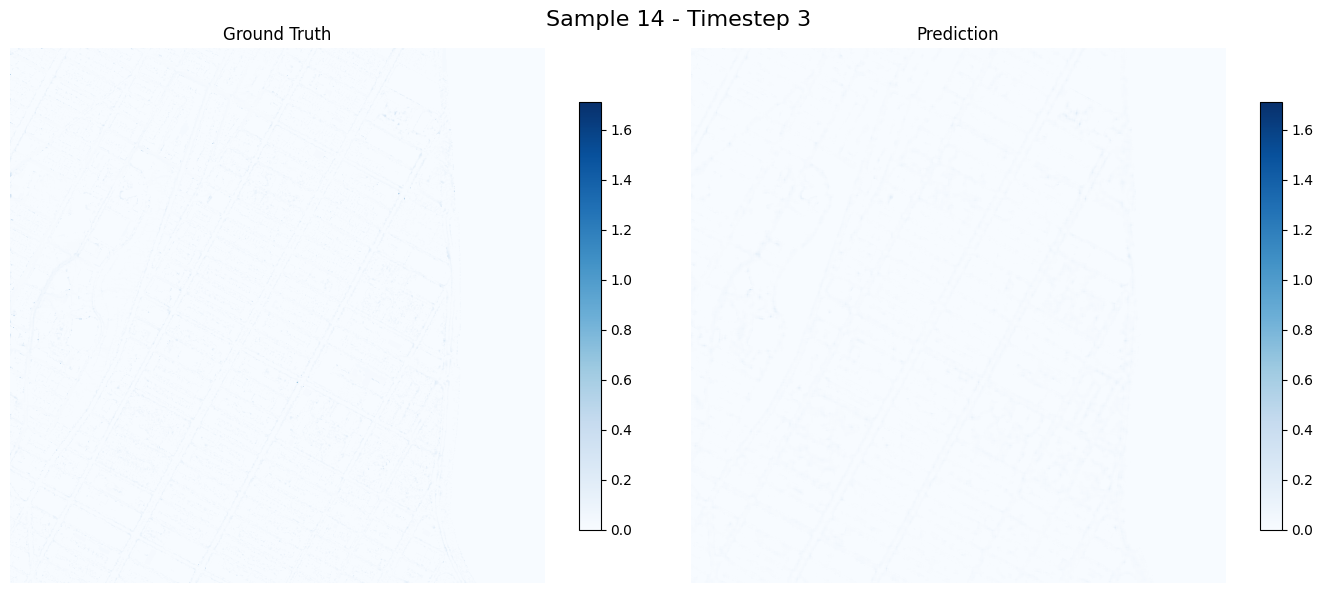


Sample 15 Prediction Stats:
  Min: 0.0
  Max: 4.26322
  Mean: 0.026839174


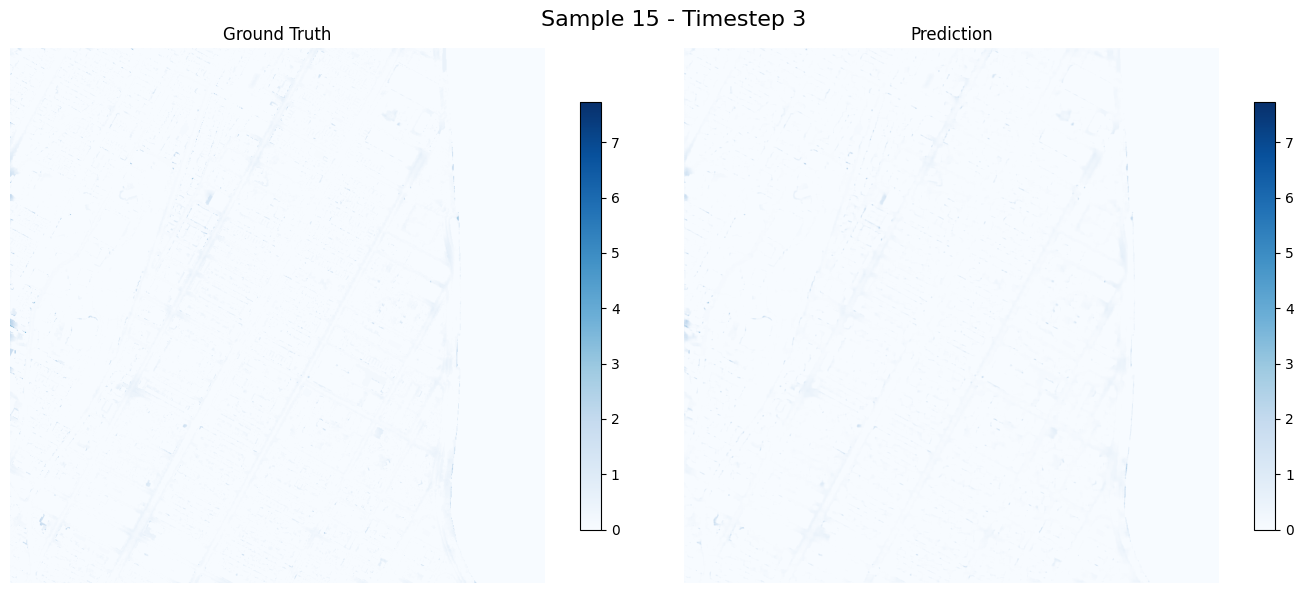


Sample 16 Prediction Stats:
  Min: 0.0
  Max: 4.512206
  Mean: 0.039776158


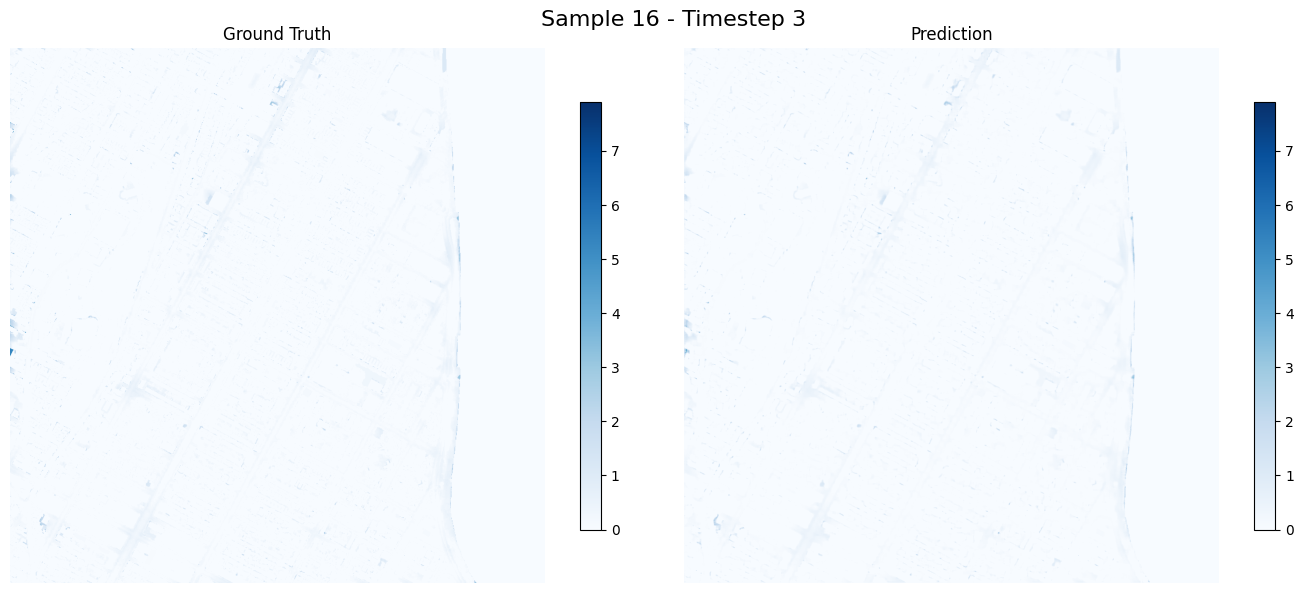


Sample 17 Prediction Stats:
  Min: 0.0
  Max: 4.5738735
  Mean: 0.01125341


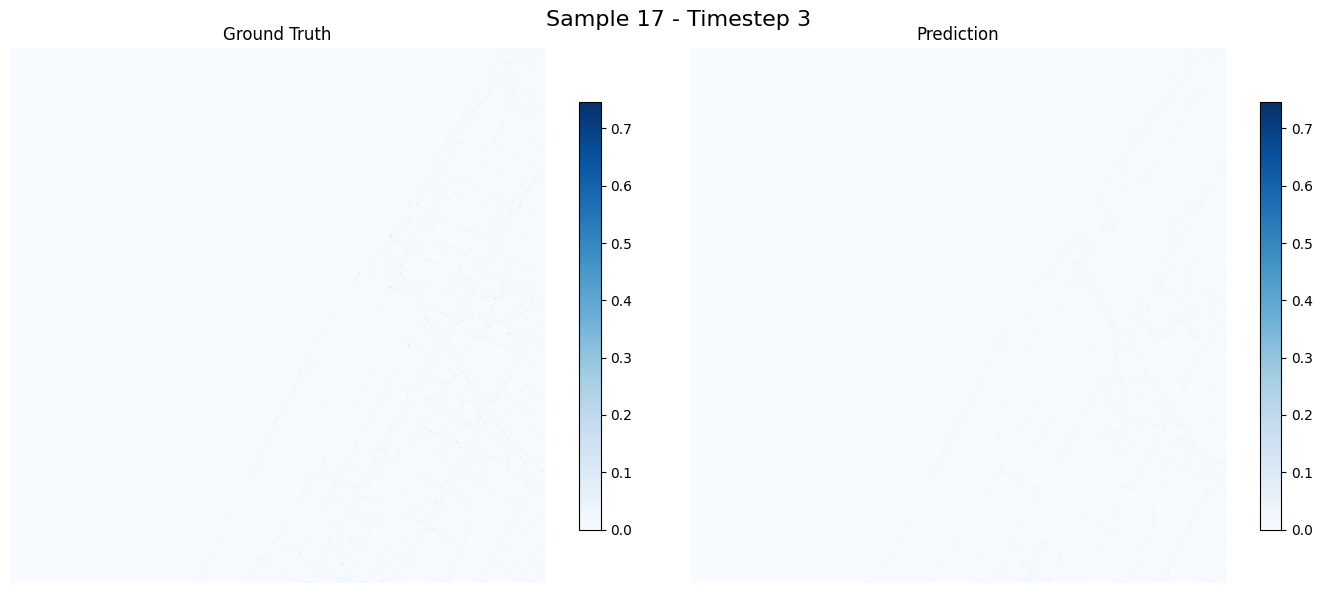


Sample 18 Prediction Stats:
  Min: 0.0
  Max: 2.950964
  Mean: 0.0091575105


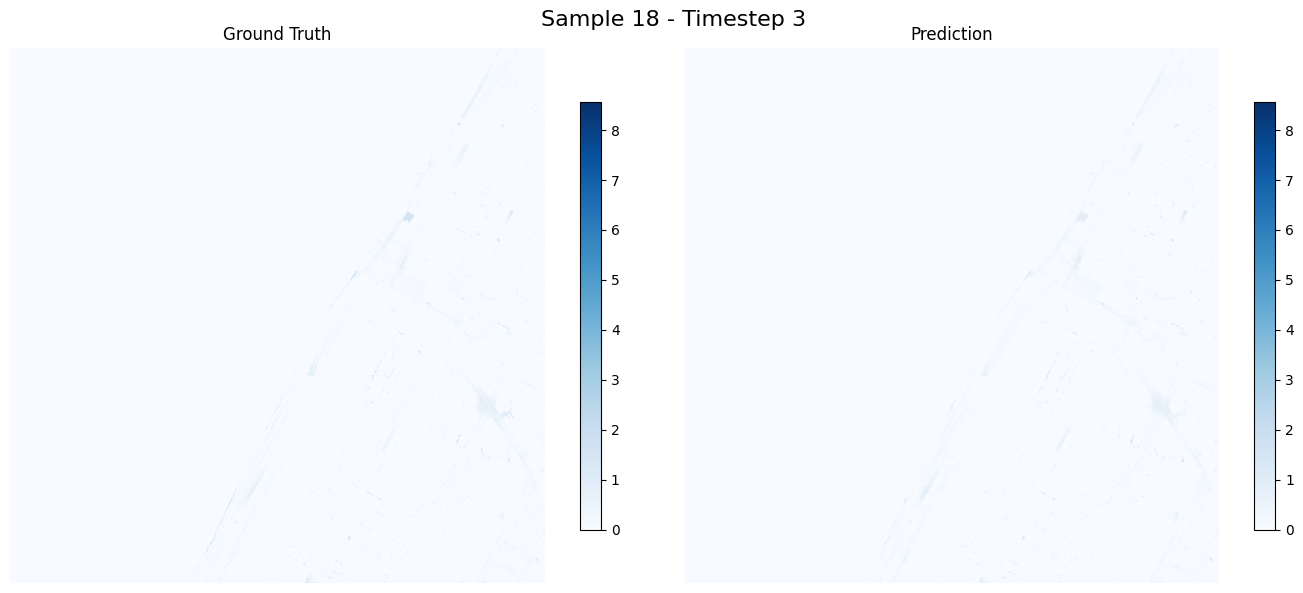


Sample 19 Prediction Stats:
  Min: 0.0
  Max: 4.234519
  Mean: 0.018113485


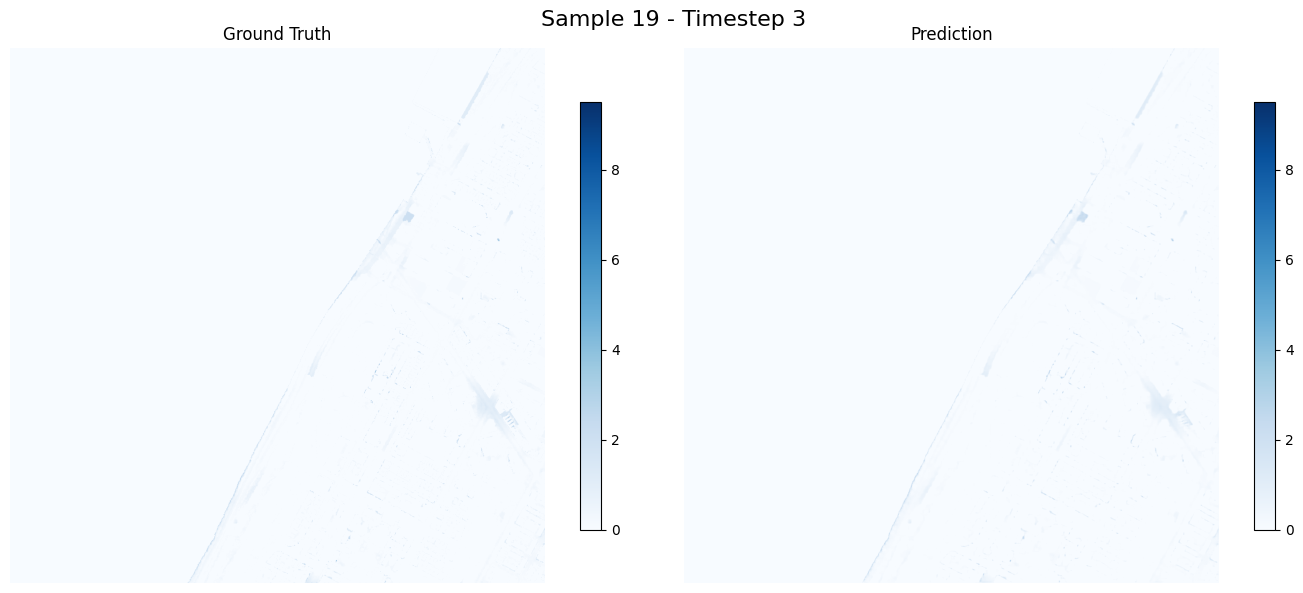


Sample 20 Prediction Stats:
  Min: 0.0
  Max: 4.264598
  Mean: 0.010633662


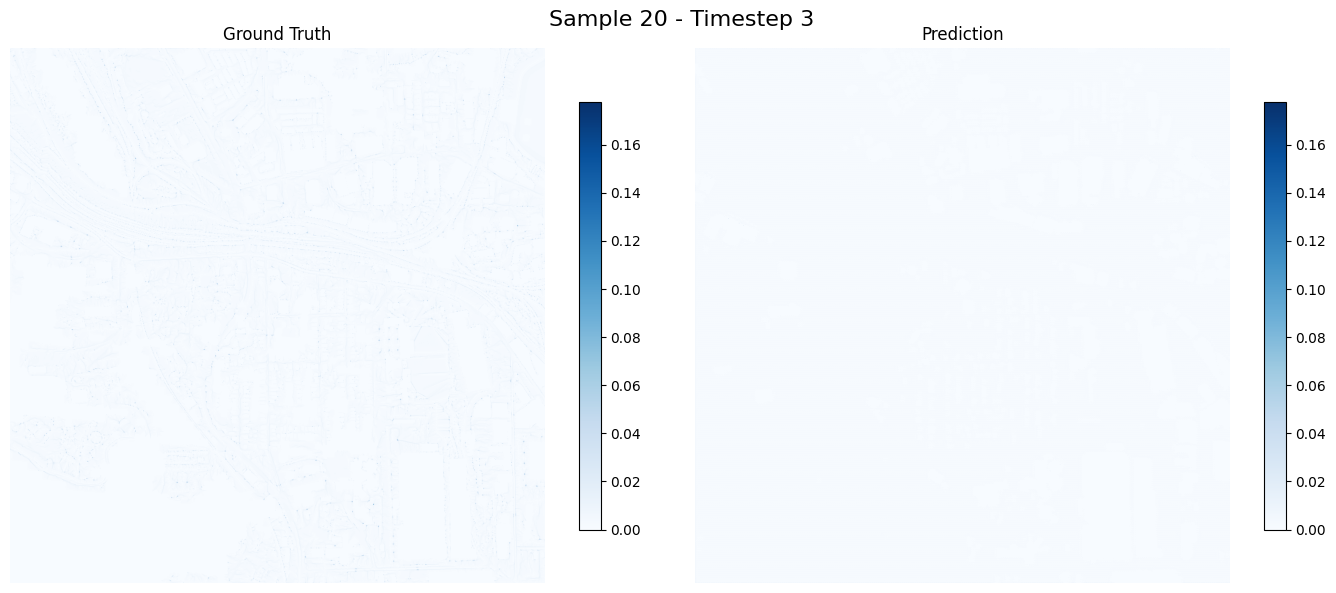

In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from usl_models.flood_ml.dataset import load_dataset_windowed
from usl_models.flood_ml import constants

# Path to trained model
model_path = "/home/vupparal/climateiq-cnn-2/logs/htune_project_20250827-180924/model"
model = tf.keras.models.load_model(model_path)

# Number of samples to visualize
n_samples = 20

# Loop through the dataset and predict
for i, (input_data, ground_truth) in enumerate(validation_dataset.take(n_samples)):
    ground_truth = ground_truth.numpy().squeeze()
    prediction = model(input_data).numpy().squeeze()

    print(f"\nSample {i+1} Prediction Stats:")
    print("  Min:", prediction.min())
    print("  Max:", prediction.max())
    print("  Mean:", prediction.mean())

    # Choose timestep to plot
    timestep = 3
    gt_t = ground_truth[timestep]
    pred_t = prediction[timestep]
    vmax_val = max(gt_t.max(), pred_t.max())

    # Plot Ground Truth and Prediction
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f"Sample {i+1} - Timestep {timestep}", fontsize=16)

    im1 = axes[0].imshow(gt_t, cmap="Blues", vmin=0, vmax=vmax_val)
    axes[0].set_title("Ground Truth")
    axes[0].axis("off")
    plt.colorbar(im1, ax=axes[0], shrink=0.8)

    im2 = axes[1].imshow(pred_t, cmap="Blues", vmin=0, vmax=vmax_val)
    axes[1].set_title("Prediction")
    axes[1].axis("off")
    plt.colorbar(im2, ax=axes[1], shrink=0.8)

    plt.tight_layout()
    plt.show()


In [37]:
import inspect, importlib, usl_models.flood_ml.dataset as dset

print("Using file:", inspect.getsourcefile(dset))
print("download_dataset defined at:", dset.download_dataset.__code__.co_filename)
print("Has _is_prediction_sim?", hasattr(dset, "_is_prediction_sim"))

# If this path is NOT your editable working copy, reload from source:
importlib.reload(dset)

# Re-print to confirm
print("Reloaded from:", dset.download_dataset.__code__.co_filename)


Using file: /home/vupparal/climateiq-cnn-2/usl_models/usl_models/flood_ml/dataset.py
download_dataset defined at: /home/vupparal/climateiq-cnn-2/usl_models/usl_models/flood_ml/dataset.py
Has _is_prediction_sim? True
Reloaded from: /home/vupparal/climateiq-cnn-2/usl_models/usl_models/flood_ml/dataset.py


In [ ]:
# ============================
# 🔧 BASIC SETTINGS
# ============================
from pathlib import Path
from usl_models.flood_ml.dataset import download_dataset, load_dataset_cached, load_prediction_dataset_cached

# 1) Set your simulation(s) here. For your test:
sim_names = ["Atlanta_Prediction"] 

# 2) File cache location (adjust if your notebook defines a different path)
filecache_dir = Path("./filecache")

# 3) Common dataset params (keep your existing values if already defined above)
dataset_split   = "train"          # used only for training sims
dataset_splits  = ["train"]        # used only in download_dataset for training sims
batch_size      = 4
n_flood_maps    = constants.N_FLOOD_MAPS
m_rainfall      = constants.M_RAINFALL
max_chunks      = None             # or an int if you want to limit

# Helper (mirrors the module’s logic; harmless if duplicated)
def _is_prediction_sim(name: str) -> bool:
    return "prediction" in name.lower()

# ============================
# 📥 STEP 1 — DOWNLOAD (run once)
# ============================
# Run this ONCE to populate the local filecache. Then comment it out for subsequent runs.
print(":inbox_tray: Downloading simulations into local cache...")
download_dataset(
    sim_names=sim_names,
    output_path=filecache_dir,
    dataset_splits=dataset_splits,  # ignored for prediction sims
)
print(":white_check_mark: Download complete.")
# After the first successful run, comment out the 3 lines above per Sally's guidance.

# ============================
# 📦 STEP 2 — LOAD FROM CACHE
# ============================
is_prediction_run = all(_is_prediction_sim(s) for s in sim_names)
is_training_run   = all(not _is_prediction_sim(s) for s in sim_names)

if not (is_prediction_run or is_training_run):
    raise ValueError(
        "Do not mix prediction and training sims in a single run. "
        "Load prediction sims and training sims in separate runs."
    )

if is_prediction_run:
    # ---- PREDICTION PATH (NO LABELS) ----
    assert len(sim_names) == 1, "Load one prediction sim at a time for clarity."
    pred_sim = sim_names[0]

    print(f":crystal_ball: Loading cached prediction dataset for {pred_sim} ...")
    ds_pred = load_prediction_dataset_cached(
        filecache_dir=filecache_dir,
        sim_name=pred_sim,
        batch_size=batch_size,
        n_flood_maps=n_flood_maps,
        m_rainfall=m_rainfall,
    )
    print(":white_check_mark: Prediction dataset ready. Elements are (features, metadata).")

    # ✅ Sanity check: ensure there are NO labels and shapes look right
    for features, meta in ds_pred.take(1):
        print("Feature keys:", list(features.keys()))
        print("geospatial:", features["geospatial"].shape)
        print("temporal:", features["temporal"].shape)
        print("spatiotemporal:", features["spatiotemporal"].shape)
        # meta contains info like {'feature_chunk': <str>, 'rainfall': <int>}
        print("metadata example:", {k: (v.numpy() if hasattr(v, "numpy") else v) for k, v in meta.items()})

else:
    # ---- TRAIN/VAL/TEST PATH (WITH LABELS) ----
    print(f":open_file_folder: Loading cached {dataset_split} dataset ...")
    ds = load_dataset_cached(
        filecache_dir=filecache_dir,
        sim_names=sim_names,
        dataset_split=dataset_split,
        batch_size=batch_size,
        n_flood_maps=n_flood_maps,
        m_rainfall=m_rainfall,
        max_chunks=max_chunks,
        shuffle=True,
    )
    print(":white_check_mark: Training dataset ready. Elements are (features, labels).")

    # ✅ Sanity check for training path
    for features, labels in ds.take(1):
        print("Feature keys:", list(features.keys()))
        print("labels:", labels.shape)


:inbox_tray: Downloading simulations into local cache...
[Prediction] Inputs-only download for: Atlanta_Prediction
[Prediction] Inputs-only download for: Atlanta_Prediction
  Trying prefix: gs://test-climateiq-study-area-feature-chunks/Atlanta_Prediction/
    ✓ Atlanta_Prediction/scaled_chunk_0_0.npy -> filecache/Atlanta_Prediction/scaled_chunk_0_0.npy
    ✓ Atlanta_Prediction/scaled_chunk_0_1.npy -> filecache/Atlanta_Prediction/scaled_chunk_0_1.npy
    ✓ Atlanta_Prediction/scaled_chunk_0_2.npy -> filecache/Atlanta_Prediction/scaled_chunk_0_2.npy
    ✓ Atlanta_Prediction/scaled_chunk_0_3.npy -> filecache/Atlanta_Prediction/scaled_chunk_0_3.npy
    ✓ Atlanta_Prediction/scaled_chunk_0_4.npy -> filecache/Atlanta_Prediction/scaled_chunk_0_4.npy
    ✓ Atlanta_Prediction/scaled_chunk_0_5.npy -> filecache/Atlanta_Prediction/scaled_chunk_0_5.npy
    ✓ Atlanta_Prediction/scaled_chunk_0_6.npy -> filecache/Atlanta_Prediction/scaled_chunk_0_6.npy
    ✓ Atlanta_Prediction/scaled_chunk_1_0.npy -> fi

In [39]:
from pathlib import Path
sim = "Atlanta_Prediction"
p = Path(filecache_dir) / sim

# count all npy files that actually exist
all_npy = list(p.rglob("*.npy"))
print("Local npy files:", len(all_npy))
print("Example:", [str(f) for f in all_npy[:5]])


Local npy files: 56
Example: ['filecache/Atlanta_Prediction/scaled_chunk_2_3.npy', 'filecache/Atlanta_Prediction/scaled_chunk_1_1.npy', 'filecache/Atlanta_Prediction/scaled_chunk_3_2.npy', 'filecache/Atlanta_Prediction/scaled_chunk_5_2.npy', 'filecache/Atlanta_Prediction/scaled_chunk_2_5.npy']
